In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import ttest_rel
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, average_precision_score

# Load data

In [2]:
df = pd.read_csv('hotel_final_features.csv')

In [3]:
df.head()

,lead_time,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,total_of_special_requests,previous_cancellations,is_canceled
0,342,True,False,False,0,0,0
1,737,True,False,False,0,0,0
2,7,True,False,False,0,0,0
3,13,True,False,False,0,0,0
4,14,True,False,False,1,0,0


In [4]:
features = ['lead_time', 
            'deposit_type_No Deposit', 'deposit_type_Non Refund', 'deposit_type_Refundable',
            'total_of_special_requests', 'previous_cancellations'
           ]

X = df[features]
y = df['is_canceled']

In [5]:
# check for imbalance
y.value_counts()

is_canceled
0    74737
1    44152
Name: count, dtype: int64

# Models

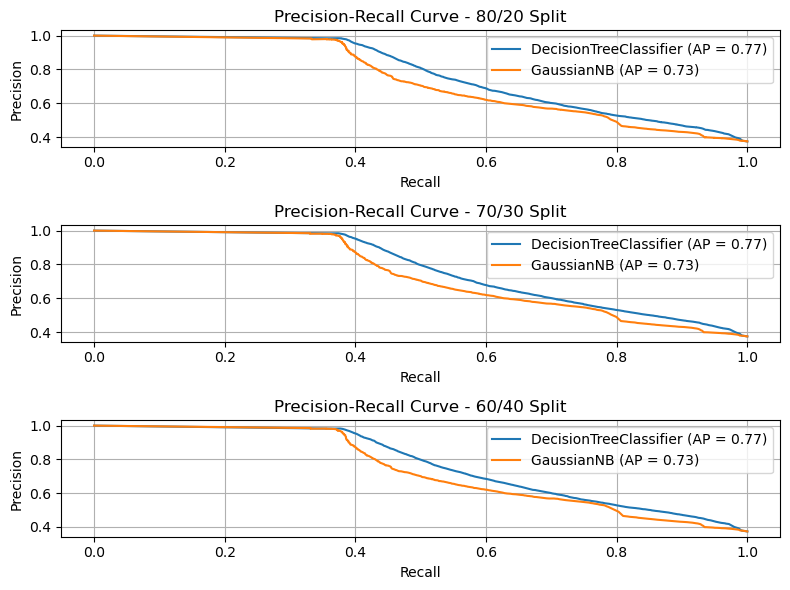

In [6]:
# initialise both models
tree = DecisionTreeClassifier(criterion='entropy', splitter='best', random_state=42)
nb = GaussianNB()

# lists to loop through
splits = [0.2, 0.3, 0.4]
models = [tree, nb]

# lists to collect data in
accuracies = []
model_names = []
splittings = []
precisions = []
recalls = []
f1s = []
roc_aucs = []
probs = []

# set up grid for graphs
fig, axes = plt.subplots(3, 1, figsize=(8, 6))
axes = axes.flatten()

# loop each split and model
for i, split in enumerate(splits):
    # split into train and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=split)
    train_pct = int((1 - split) * 100)
    # fix the 19% rounding anomaly
    if train_pct == 19:
        train_pct += 1
    test_pct = int(split * 100)

    for model in models:
        # for each model at this split
        name = model.__class__.__name__
        # fit the model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        # metrics
        confusion = confusion_matrix(y_test, y_pred, labels=[0, 1])
        tn, fp, fn, tp = confusion.ravel()

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, pos_label=1)
        recall = recall_score(y_test, y_pred, pos_label=1)
        f1 = f1_score(y_test, y_pred, pos_label=1)
        roc_auc = roc_auc_score(y_test, y_prob)

        # add to lists for use later
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        roc_aucs.append(roc_auc)
        probs.append(y_prob)
        model_names.append(name)
        splittings.append(f"{train_pct}/{test_pct}")

        # plot precision-recall curve
        prec, rec, _ = precision_recall_curve(y_test, y_prob)
        ap = average_precision_score(y_test, y_prob)
        axes[i].plot(rec, prec, label=f'{name} (AP = {ap:.2f})')

    axes[i].set_xlabel('Recall')
    axes[i].set_ylabel('Precision')
    axes[i].set_title(f'Precision-Recall Curve - {train_pct}/{test_pct} Split')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()

In [7]:
# Create dataframe
results_df = pd.DataFrame({
    "Model": model_names,
    "Train/Test Split": splittings,
    "Accuracy": accuracies,
    "Precision": precisions,
    "Recall (TPR)": recalls,
    "F1 Score": f1s,
    "Roc-Auc": roc_aucs
})

results_df.round(2).sort_values(by='Model')

,Model,Train/Test Split,Accuracy,Precision,Recall (TPR),F1 Score,Roc-Auc
0,DecisionTreeClassifier,80/20,0.77,0.87,0.46,0.60,0.80
2,DecisionTreeClassifier,70/30,0.77,0.87,0.46,0.60,0.80
4,DecisionTreeClassifier,60/40,0.77,0.85,0.46,0.60,0.80
1,GaussianNB,80/20,0.76,0.98,0.36,0.53,0.76
3,GaussianNB,70/30,0.76,0.98,0.35,0.52,0.76
5,GaussianNB,60/40,0.76,0.98,0.36,0.53,0.76


In [8]:
tree_f1s = results_df[results_df['Model']=='DecisionTreeClassifier']['F1 Score']
nb_f1s = results_df[results_df['Model']=='GaussianNB']['F1 Score']

t_stat, p_value = ttest_rel(tree_f1s, nb_f1s)

print(f"t = {t_stat:.3f}, p = {p_value:.3f}")

t = 100.955, p = 0.000


## Confirmation with more models!

In [9]:
splits = [0.2, 0.3, 0.4]
seeds = range(1, 30, 2)
models = [tree, nb]

# lists to collect data in
accuracies = []
model_names = []
splittings = []
precisions = []
recalls = []
f1s = []
roc_aucs = []
probs = []
seed_nums = []

for seed in seeds:
    for model in models:
        for split in splits:
            model_names.append(model.__class__.__name__)
            seed_nums.append(seed)
                
            X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=split)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            confusion = confusion_matrix(y_test, y_pred, labels=[0, 1])
        
            train_pct = int((1 - split) * 100)
            if train_pct == 19:
                train_pct += 1
            test_pct = int(split * 100)
            splittings.append(f"{train_pct}/{test_pct}")
        
            # confusion matrix data
            tn, fp, fn, tp = confusion.ravel()
            y_prob = model.predict_proba(X_test)[:, 1]
            probs.append(y_prob)
    
            # accuracy
            accuracy = accuracy_score(y_test, y_pred)
            accuracies.append(accuracy)
        
            # precision
            precision = precision_score(y_test, y_pred, pos_label=1)
            precisions.append(precision)
        
            # recall (== true positive rate)
            recall = recall_score(y_test, y_pred, pos_label=1)
            recalls.append(recall)
            
            # F1 score
            f1 = f1_score(y_test, y_pred, pos_label=1)
            f1s.append(f1)
    
            # roc-auc
            roc_auc = roc_auc_score(y_test, y_prob)
            roc_aucs.append(roc_auc)


# Create dataframe
results_df = pd.DataFrame({
    "Model": model_names,
    "Seed": seed_nums,
    "Train/Test Split": splittings,
    "Accuracy": accuracies,
    "Precision": precisions,
    "Recall (TPR)": recalls,
    "F1 Score": f1s,
    "Roc-Auc": roc_aucs
})

results_df.round(2).sort_values(by='Model')

,Model,Seed,Train/Test Split,Accuracy,Precision,Recall (TPR),F1 Score,Roc-Auc
0,DecisionTreeClassifier,1,80/20,0.77,0.87,0.45,0.59,0.80
32,DecisionTreeClassifier,11,60/40,0.76,0.87,0.44,0.59,0.80
36,DecisionTreeClassifier,13,80/20,0.77,0.87,0.45,0.60,0.80
37,DecisionTreeClassifier,13,70/30,0.77,0.86,0.46,0.60,0.80
38,DecisionTreeClassifier,13,60/40,0.77,0.85,0.46,0.60,0.80
...,...,...,...,...,...,...,...,...
57,GaussianNB,19,80/20,0.76,0.98,0.35,0.52,0.76
58,GaussianNB,19,70/30,0.76,0.98,0.35,0.52,0.76
59,GaussianNB,19,60/40,0.76,0.98,0.35,0.52,0.76
46,GaussianNB,15,70/30,0.76,0.98,0.35,0.52,0.76


In [10]:
tree_f1s = results_df[results_df['Model']=='DecisionTreeClassifier']['F1 Score']
nb_f1s = results_df[results_df['Model']=='GaussianNB']['F1 Score']

In [11]:
t_stat, p_value = ttest_rel(tree_f1s, nb_f1s)

print(f"t = {t_stat:.3f}, p = {p_value:.3f}")

t = 56.937, p = 0.000
